In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [2]:
# Step 1: Fetch ETF Data
def fetch_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        etf = yf.download(ticker, start=start, end=end)['Adj Close']
        data[ticker] = etf
    return pd.DataFrame(data)

# Define ETFs representing the factors
etf_tickers = {
    "Value": "VTV",        # Vanguard Value ETF
    "Momentum": "MTUM",    # iShares Momentum ETF
    "Growth": "VUG",       # Vanguard Growth ETF
    "Quality": "QUAL",     # iShares Quality Factor ETF
    "Size": "IJR"          # iShares Small-Cap ETF
}

start_date = "2018-01-01"
end_date = "2024-09-30"
prices = fetch_data(etf_tickers.values(), start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Step 2: Calculate Factor Returns
returns = prices.pct_change().dropna()

In [5]:
# Step 3: Mean-Variance Optimization
def mean_variance_optimization(expected_returns, cov_matrix, turnover_penalty, prev_weights, bounds):
    num_assets = len(expected_returns)

    # Objective: Maximize Sharpe Ratio with Turnover Penalty
    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        turnover = np.sum(np.abs(weights - prev_weights))
        return -portfolio_return / portfolio_volatility + turnover_penalty * turnover

    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]  # Weights sum to 1

    # Bounds
    bounds = [(0.1, 0.4) for _ in range(num_assets)]  # Min weight = 10%, Max weight = 40%

    # Initial Guess
    init_guess = np.array([1/num_assets] * num_assets)

    # Optimization
    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [6]:
# Step 4: Markov Switching Model for Regime Detection
def markov_regimes(returns, n_regimes=2):
    gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', random_state=42)
    gmm.fit(returns)
    probabilities = gmm.predict_proba(returns)
    return probabilities, gmm.predict(returns)

In [32]:
# Step 5: Dynamic Rebalancing
def backtest_strategy(
    returns, etf_names, rebalance_period=63, turnover_penalty=0.01, cash_buffer=0.02, transaction_cost=0.001
):
    n_assets = len(etf_names)
    weights = np.zeros((len(returns), n_assets))  # Store weights for all dates
    prev_weights = np.array([(1 - cash_buffer) / n_assets] * n_assets)  # Initial equal weights
    portfolio_returns = np.zeros(len(returns))  # Ensure length matches returns

    # Rolling optimization and rebalancing
    for t in range(0, len(returns), rebalance_period):
        # Data window for optimization
        end_idx = min(t + rebalance_period, len(returns))  # Handle last window
        window_returns = returns.iloc[t:end_idx]
        expected_returns = window_returns.mean()
        cov_matrix = window_returns.cov()

        # Define bounds: Min 10%, Max 40% for each factor
        bounds = [(0.1, 0.4) for _ in range(n_assets)]

        # Define constraints
        constraints = [
            {"type": "eq", "fun": lambda w: np.sum(w) - (1 - cash_buffer)},  # Ensure total weight = 1 - cash buffer
            {"type": "ineq", "fun": lambda w: 0.6 - (w[0] + w[2])},  # Ensure Value + Growth ≤ 60%
        ]

        # Optimize weights
        optimal_weights = mean_variance_optimization(expected_returns, cov_matrix, turnover_penalty, prev_weights, bounds, constraints)
        weights[t:end_idx] = optimal_weights  # Assign optimized weights
        prev_weights = optimal_weights

        # Calculate portfolio returns
        for i in range(t, end_idx):
            gross_return = np.dot(optimal_weights, returns.iloc[i])
            turnover_cost = transaction_cost * np.sum(np.abs(optimal_weights - prev_weights))
            net_return = gross_return - turnover_cost
            portfolio_returns[i] = net_return

    return weights, portfolio_returns

In [41]:
def calculate_performance_metrics(portfolio_returns, benchmark_returns, risk_free_rate=0.02):
    """
    Create a table comparing performance metrics for the portfolio strategy and S&P 500 benchmark,
    including Total Return as part of the metrics.
    """
    def calculate_metrics(returns):
        cumulative_returns = np.cumprod(1 + returns)
        total_return = cumulative_returns[-1] - 1
        annualized_return = (cumulative_returns[-1]) ** (252 / len(returns)) - 1
        volatility = np.std(returns) * np.sqrt(252)
        sharpe_ratio = (annualized_return - risk_free_rate) / volatility

        # Max drawdown
        cumulative_peaks = np.maximum.accumulate(cumulative_returns)
        drawdown = (cumulative_returns / cumulative_peaks) - 1
        max_drawdown = drawdown.min()

        # Sortino ratio (using downside deviation)
        downside_returns = returns[returns < 0]
        downside_deviation = np.std(downside_returns) * np.sqrt(252)
        sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

        return {
            "Total Return": total_return * 100,
            "Annualized Return": annualized_return * 100,
            "Volatility": volatility * 100,  # Annualized volatility
            "Sharpe Ratio": sharpe_ratio,
            "Sortino Ratio": sortino_ratio,
            "Max Drawdown": max_drawdown * 100,
        }

    # Calculate metrics for portfolio and benchmark
    portfolio_metrics = calculate_metrics(portfolio_returns)
    benchmark_metrics = calculate_metrics(benchmark_returns)

    # Create a DataFrame for comparison
    metrics_df = pd.DataFrame({
        "Smart Beta Strategy": portfolio_metrics,
        "S&P 500 Benchmark": benchmark_metrics
    })

    return metrics_df

[*********************100%%**********************]  1 of 1 completed


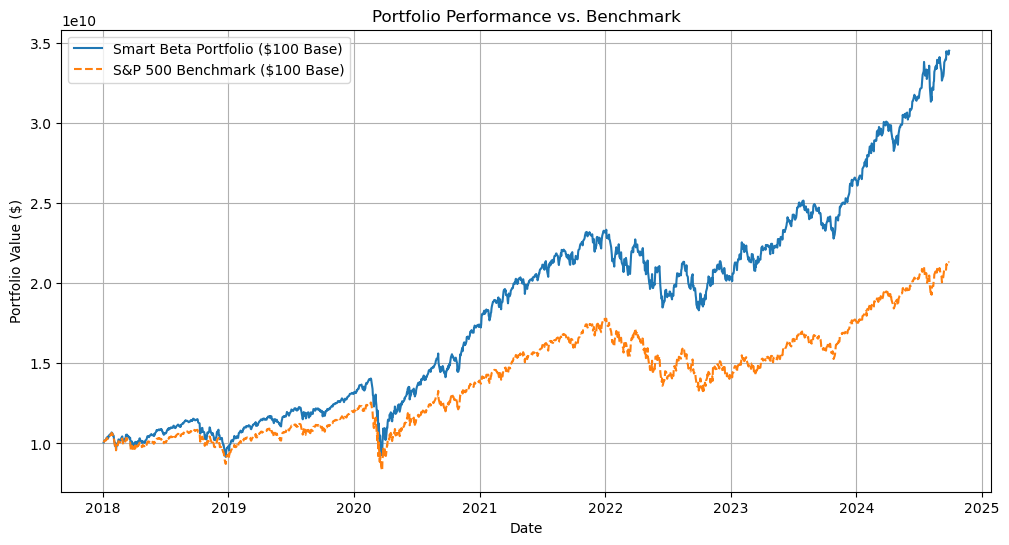

                   Smart Beta Strategy  S&P 500 Benchmark
Total Return                245.178047         112.855127
Annualized Return            20.224300          11.886350
Volatility                   19.971589          19.943687
Sharpe Ratio                  0.912511           0.495713
Sortino Ratio                 1.124537           0.603313
Max Drawdown                -34.124382         -33.924960


In [42]:
# Fetch S&P 500 Benchmark Data
sp500_prices = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
sp500_returns = sp500_prices.pct_change().dropna()
sp500_cumulative = np.cumprod(1 + sp500_returns)

# Portfolio Cumulative Returns
portfolio_cumulative = np.cumprod(1 + portfolio_returns)

# Merge Data for Comparison
# Convert cumulative returns to a base of $100
comparison_df['Smart Beta Portfolio'] = comparison_df['Smart Beta Portfolio'] * 100
comparison_df['S&P 500'] = comparison_df['S&P 500'] * 100

# Plot with $100 Base Investment
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Smart Beta Portfolio'], label="Smart Beta Portfolio ($100 Base)")
plt.plot(comparison_df['S&P 500'], label="S&P 500 Benchmark ($100 Base)", linestyle="--")
plt.title("Portfolio Performance vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid()
plt.show()

# Print performance metrics for both portfolios
# portfolio_metrics = calculate_performance_metrics(portfolio_returns)
# benchmark_metrics = calculate_performance_metrics(sp500_returns.values[:len(portfolio_returns)])

# Calculate metrics table with total return
metrics_table_with_total_return = calculate_performance_metrics(portfolio_returns, sp500_returns)

# Print the table
print(metrics_table_with_total_return)